## Import Dependencies

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from keras.layers import  Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm

## Download the Pretrained Embeddings

In [6]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip

--2024-12-21 13:50:09--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2024-12-21 13:50:09--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2024-12-21 13:50:10--  https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/

## Fetch the Data

In [35]:
df = pd.read_csv('/content/jigsaw-toxic-comment-train-processed-seqlen128.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,input_word_ids,input_mask,all_segment_id
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"(101, 27746, 31609, 11809, 24781, 10105, 70971...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"(101, 141, 112, 56237, 10874, 106, 10357, 1825...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"(101, 35936, 10817, 117, 146, 112, 181, 30181,...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"(101, 107, 15946, 146, 10944, 112, 188, 13086,...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"(101, 11065, 117, 52523, 117, 10301, 15127, 51...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Data Preprocessing

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              223549 non-null  object
 1   comment_text    223549 non-null  object
 2   toxic           223549 non-null  int64 
 3   severe_toxic    223549 non-null  int64 
 4   obscene         223549 non-null  int64 
 5   threat          223549 non-null  int64 
 6   insult          223549 non-null  int64 
 7   identity_hate   223549 non-null  int64 
 8   input_word_ids  223549 non-null  object
 9   input_mask      223549 non-null  object
 10  all_segment_id  223549 non-null  object
dtypes: int64(6), object(5)
memory usage: 18.8+ MB


In [37]:
df.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [38]:
df = df.loc[:12000,:]
df.shape

(12001, 6)

In [10]:
df['comment_text'].apply(lambda x:len(str(x).split())).max()

1403

In [11]:
def roc_auc(predictions,target):

    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [12]:
xtrain, xvalid, ytrain, yvalid = train_test_split(df.comment_text.values, df.toxic.values,
                                                  stratify=df.toxic.values,
                                                  random_state=10,
                                                  test_size=0.2, shuffle=True)

## Tokenization | Padding

In [13]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

## Fetch Pretrained Glove Embeddings: [Link](https://nlp.stanford.edu/projects/glove/)

In [14]:
embeddings_index = {}
f = open('/content/glove.840B.300d.txt','r',encoding='utf-8')

for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [04:03, 9034.48it/s]

Found 2196016 word vectors.


In [15]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 43496/43496 [00:00<00:00, 228201.20it/s]


## Model 1 | Gated Recurrent Unit
- `glove embeddings`
- `Spatial Dropout layer`
- `1 dense layer`
- `1 Output layer`

In [16]:
model1 = Sequential()

model1.add(Embedding(len(word_index) + 1,
                    300,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))

model1.add(SpatialDropout1D(0.3))
model1.add(GRU(300))

model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      13,049,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,049,100 (49.78 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 13,049,100 (49.78 MB)

In [17]:
history1 = model1.fit(xtrain_pad, ytrain, epochs=5, batch_size=64)

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 151ms/step - accuracy: 0.9089 - loss: 0.2640
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 156ms/step - accuracy: 0.9566 - loss: 0.1260
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 160ms/step - accuracy: 0.9646 - loss: 0.0976
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - accuracy: 0.9616 - loss: 0.0959
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - accuracy: 0.9706 - loss: 0.0826


In [18]:
scores = model1.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step
Auc: 0.97%


## Model 2 | Bi-Directional LSTM
- `Pre-Trained Glove Embeddings`
- `Bidirectional LSTM`
- `1 Dense Layer`
- `1 Output layer`

In [19]:
model2 = Sequential()

model2.add(Embedding(len(word_index) + 1,
                    300,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))

model2.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │      13,049,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,049,100 (49.78 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 13,049,100 (49.78 MB)

In [21]:
history2 = model2.fit(xtrain_pad, ytrain, epochs=5, batch_size=64)

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 550s 4s/step - accuracy: 0.9125 - loss: 0.2753
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 518s 3s/step - accuracy: 0.9438 - loss: 0.1618
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 517s 3s/step - accuracy: 0.9510 - loss: 0.1409
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 576s 4s/step - accuracy: 0.9483 - loss: 0.1466
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 560s 4s/step - accuracy: 0.9611 - loss: 0.1121


In [22]:
scores = model2.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

76/76 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step
Auc: 0.97%


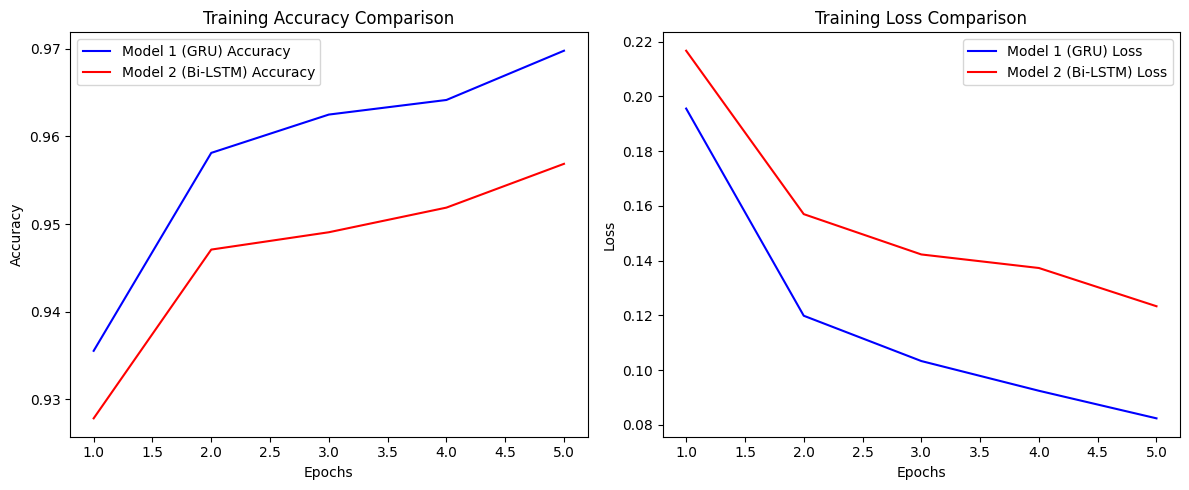

In [39]:
import matplotlib.pyplot as plt

accuracy1 = history1.history['accuracy']
loss1 = history1.history['loss']
accuracy2 = history2.history['accuracy']
loss2 = history2.history['loss']

epochs = range(1, len(accuracy1) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy1, 'b', label='Model 1 (GRU) Accuracy')
plt.plot(epochs, accuracy2, 'r', label='Model 2 (Bi-LSTM) Accuracy')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss1, 'b', label='Model 1 (GRU) Loss')
plt.plot(epochs, loss2, 'r', label='Model 2 (Bi-LSTM) Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()